In [4]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from scipy import stats
import scipy.io as sio
import h5py

In [5]:
def run_experiment(path, input_size, Layer_out, class_output, batch_size, learning_rate, iteration):
    
    # Read in data
    data = h5py.File(path, 'r')
    X = np.array(data['image_patch'])
    Y = np.array(data['road_existence'])
    data.close()

    # Reorder & Create masks
    index_mask = np.arange(X.shape[0])
    np.random.shuffle(index_mask)

    train_mask = index_mask[:int(index_mask.size*0.75)]
    test_mask = index_mask[int(index_mask.size*0.75):]

    train_x = X[train_mask].flatten().reshape((train_mask.size, -1))
    train_y = Y[train_mask]
    train_mask = np.arange(train_x.shape[0])
    np.random.shuffle(train_mask)

    test_x = X[test_mask].flatten().reshape((test_mask.size, -1))
    test_y = Y[test_mask]
    test_mask = np.arange(test_x.shape[0])
    np.random.shuffle(test_mask)

    # Normalize Parameters
    mu = train_x.mean(axis=0, keepdims=True)
    sigma = 0
    for img in train_x:
        sigma += (img-mu)**2
    sigma /= train_x.shape[0]

    # layer parameter
    L1_out = Layer_out[1]
    L2_out = Layer_out[2]
    L3_out = Layer_out[3]
    L4_out = Layer_out[4]
    
    x = tf.placeholder(tf.float32, shape=[None, input_size])
    y = tf.placeholder(tf.float32, shape=[None, class_output])

    # Layer 1
    W_fc1 = tf.Variable(tf.truncated_normal([input_size, L1_out], stddev=0.1))
    b_fc1 = tf.Variable(tf.truncated_normal([L1_out], stddev=0.1))

    fc1=tf.matmul(x, W_fc1) + b_fc1 # applying weights and biases
    h_fc1 = tf.nn.relu(fc1) # ReLU activation

    # Layer 2
    W_fc2 = tf.Variable(tf.truncated_normal([L1_out, L2_out], stddev=0.1))
    b_fc2 = tf.Variable(tf.truncated_normal([L2_out], stddev=0.1))

    fc2=tf.matmul(h_fc1, W_fc2) + b_fc2# applying weights and biases
    h_fc2 = tf.nn.relu(fc2) # ReLU activation

    # Layer 3
    W_fc3 = tf.Variable(tf.truncated_normal([L2_out, L3_out], stddev=0.1))
    b_fc3 = tf.Variable(tf.truncated_normal([L3_out], stddev=0.1))

    fc3=tf.matmul(h_fc2, W_fc3) + b_fc3
    h_fc3 = tf.nn.relu(fc3) # ReLU activation

    # Layer 4
    W_fc4 = tf.Variable(tf.truncated_normal([L3_out, L4_out], stddev=0.1))
    b_fc4 = tf.Variable(tf.truncated_normal([L4_out], stddev=0.1))

    fc4=tf.matmul(h_fc3, W_fc4) + b_fc4
    h_fc4 = tf.nn.relu(fc4) # ReLU activation

    W_fc_out = tf.Variable(tf.truncated_normal([L4_out, class_output], stddev=0.1))
    b_fc_out = tf.Variable(tf.truncated_normal([class_output], stddev=0.1))

    fc_out=tf.matmul(h_fc4, W_fc_out) + b_fc_out

    y_CNN= tf.sigmoid(fc_out)
    prediction = tf.cast(tf.round(y_CNN), tf.int32)

    cross_entropy = -tf.reduce_mean(tf.reduce_sum((y * tf.log(y_CNN) + (1-y) * tf.log(1-y_CNN)), axis=1))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

    accuracy = tf.reduce_mean(tf.cast(tf.equal(y, tf.round(y_CNN)), "float"))

    batch_num = int(train_mask.size/batch_size)

    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    # start training
    learning_curve = []
    F1_curve = []
    for i in range(iteration):
        start = i%batch_num * batch_size
        end = start + batch_size

        if end > train_mask.size:
            end = train_mask.size
            np.random.shuffle(train_mask)

        train_index = train_mask[start:end]    
        batch = [((train_x[train_index]-mu)/sigma), np.matrix(train_y[train_index]).astype(int).T]

        # snap shot
        if i%1000 == 0:
            pred = prediction.eval(feed_dict={x:batch[0], y: batch[1]})
            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y: batch[1]})

            # compute metric
            true_neg = np.logical_and(pred == batch[1], np.logical_not(batch[1])).sum()
            false_neg = (np.logical_not(batch[1]).sum()) - true_neg
            true_pos = (np.logical_and(pred == batch[1], batch[1])).sum()
            false_pos = batch[1].sum() - true_pos

            precision = true_neg / (true_neg + false_neg)
            recall = true_neg / (true_neg + false_pos)

            train_F1_score = 2*(recall*precision) / (recall+precision)

            learning_curve.append(train_accuracy)
            F1_curve.append(train_F1_score)

        train_step.run(feed_dict={x: batch[0], y: batch[1]})

    # evaluae on training set
    train_acc = []
    train_F1 = []
    batch_num = int(train_mask.size/batch_size)
    for i in range(batch_num+1):
        start = i%batch_num * batch_size
        end = start + batch_size

        if end > train_mask.size:
            end = train_mask.size

        batch = [((train_x[start:end]-mu)/sigma), np.matrix(train_y[start:end]).T]

        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y: batch[1]})
        train_acc.append(train_accuracy * (end-start))

        # compute metric   
        pred = prediction.eval(feed_dict={x:batch[0], y: batch[1]})

        true_neg = np.logical_and(pred == batch[1], np.logical_not(batch[1])).sum()
        false_neg = (np.logical_not(batch[1]).sum()) - true_neg
        true_pos = (np.logical_and(pred == batch[1], batch[1])).sum()
        false_pos = batch[1].sum() - true_pos

        precision = true_neg / (true_neg + false_neg)
        recall = true_neg / (true_neg + false_pos)     

        train_F1.append(2*(recall*precision) / (recall+precision)* (end-start))

    print("train_acc = ", sum(train_acc)/train_mask.size, " train_F1 = ", sum(train_F1)/train_mask.size)

    # evaluae on test set
    test_acc = []
    test_F1 = []
    batch_num = int(test_mask.size/batch_size)
    for i in range(batch_num+1):
        start = i%batch_num * batch_size
        end = start + batch_size

        if end > test_mask.size:
            end = test_mask.size

        batch = [((test_x[start:end]-mu)/sigma), np.matrix(test_y[start:end]).T]

        test_accuracy = accuracy.eval(feed_dict={x:batch[0], y: batch[1]})
        test_acc.append(test_accuracy * (end-start))

        # compute metric   
        pred = prediction.eval(feed_dict={x:batch[0], y: batch[1]})        

        true_neg = np.logical_and(pred == batch[1], np.logical_not(batch[1])).sum()
        false_neg = (np.logical_not(batch[1]).sum()) - true_neg
        true_pos = (np.logical_and(pred == batch[1], batch[1])).sum()
        false_pos = batch[1].sum() - true_pos

        precision = true_neg / (true_neg + false_neg)
        recall = true_neg / (true_neg + false_pos)     

        test_F1.append(2*(recall*precision) / (recall+precision)* (end-start))

    print("test_acc  = ", sum(test_acc)/test_mask.size, "test_F1 = ", sum(test_F1)/test_mask.size)
    
    # finish the session & clean
    sess.close()
    tf.reset_default_graph()

    # plot training curve
    fig, subfig = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18,5))
    subfig[0].plot(learning_curve)
    subfig[0].set_title('learning_curve')
    
    subfig[1].plot(F1_curve)
    subfig[1].set_title('F1_curve')
    plt.show()


../Data/090085/Road_Data/tert_uncl_track/patch_set.h5
train_acc =  0.69105944887  train_F1 =  0.806516982024
test_acc  =  0.686651914814 test_F1 =  0.803870083183


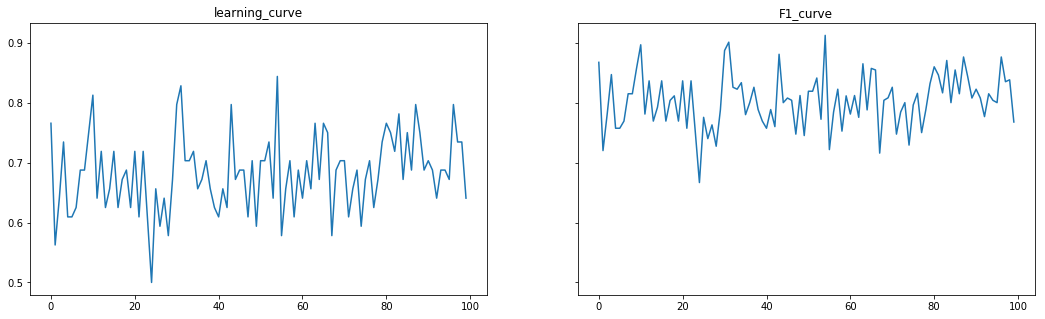

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in long_scalars


train_acc =  0.690743335272  train_F1 =  0.806599413033
test_acc  =  0.68611335511 test_F1 =  0.803711848994


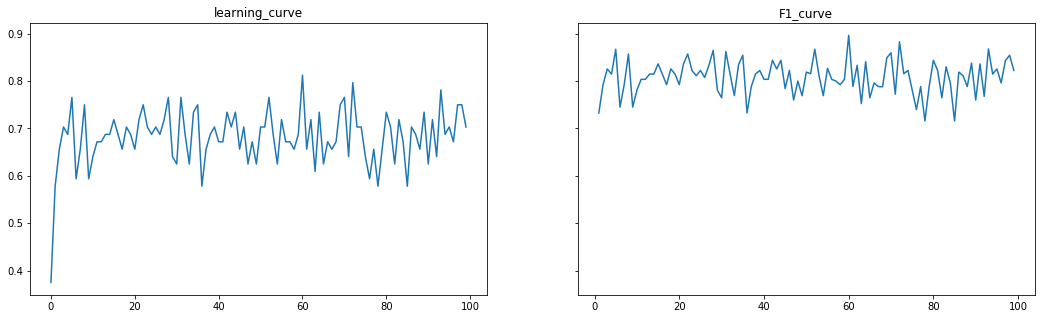

train_acc =  0.690204771364  train_F1 =  0.808007039098
test_acc  =  0.685153313898 test_F1 =  0.804678463379


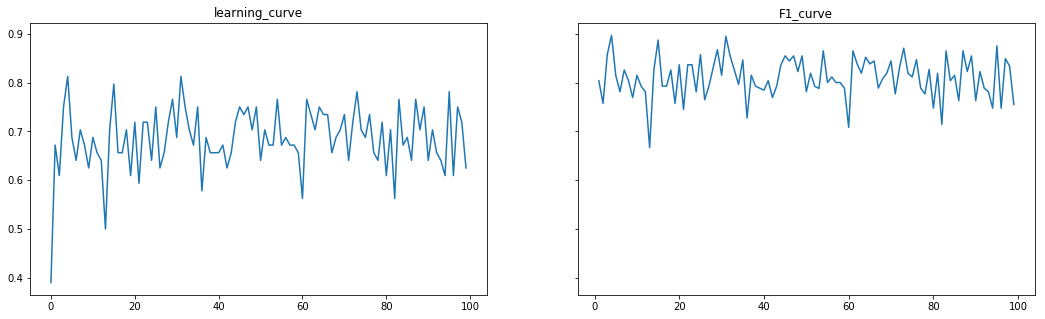

In [6]:
for data_path in ["../Data/090085/Road_Data/tert_uncl_track/patch_set.h5"]:
    print(data_path)
    for i in range(3):
        run_experiment(path=data_path,
                   input_size=28*28*7, Layer_out=[0, 512, 256, 128, 64], class_output=1,
                   batch_size=64, iteration=100000, learning_rate=5e-6)
        